# Transformers vs. ECFP4 embeddings

In [3]:
import os

import numpy as np
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def get_run_info(filepath):

    # Split the string at each slash to isolate each part of the path
    parts = filepath.split("/")

    # The target part is the one that contains 'params.dataset' and 'params.support_set_size'
    target = [part for part in parts if "params.dataset" in part and "params.feature" in part][0]

    # Split the target part at each comma
    params = target.split(",")

    # Split each parameter at the equals sign and take the second part
    dataset = params[0].split("=")[1]
    feature = params[1].split("=")[1]  # convert to int for numerical operations

    return {"feature": feature, "dataset": dataset}

In [6]:
INPUT_DIR = "/Users/sethhowes/Desktop/FS-Tox/multirun/2023-08-10/14-26-24"
run_dirs = [os.path.join(INPUT_DIR, run_dir) for run_dir in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, run_dir))]
run_dirs = [f"{run_dir}/data/processed/score/*.parquet" for run_dir in run_dirs]

datasets = ["toxcast", "toxval", "nci60", "cancerrx", "prism", "acute-oral-toxicity", "meic"]

con = duckdb.connect()

dfs = []

for run_dir in run_dirs:
    info = get_run_info(run_dir)
    query = f"""
    SELECT delta_auc_pr
    FROM read_parquet('{run_dir}')
    """
    try:
        df = con.execute(query).df()
        df["feature"] = info["feature"]
        df["dataset"] = info["dataset"]
        dfs.append(df)
    except Exception as e:
        print(f"No data for {info['dataset']} trained with feature")

        
# Concatenate all dataframes into one
df_final = pd.concat(dfs, ignore_index=True)

No data for nci60 trained with feature
No data for cancerrx trained with feature
No data for cancerrx trained with feature
No data for nci60 trained with feature
No data for toxcast trained with feature
No data for acute_oral_toxicity trained with feature
No data for acute_oral_toxicity trained with feature
No data for cancerrx trained with feature


In [4]:
df_final

,delta_auc_pr,feature,dataset
0,0.249536,ecfp4_1024,nci60
1,0.037207,ecfp4_1024,nci60
2,0.043833,ecfp4_1024,nci60
3,0.002620,ecfp4_1024,nci60
4,0.010916,ecfp4_1024,nci60
...,...,...,...
3041,0.230764,ecfp4_1024,toxval
3042,0.009216,ecfp4_1024,toxval
3043,0.039733,ecfp4_1024,toxval
3044,0.207688,ecfp4_1024,toxval


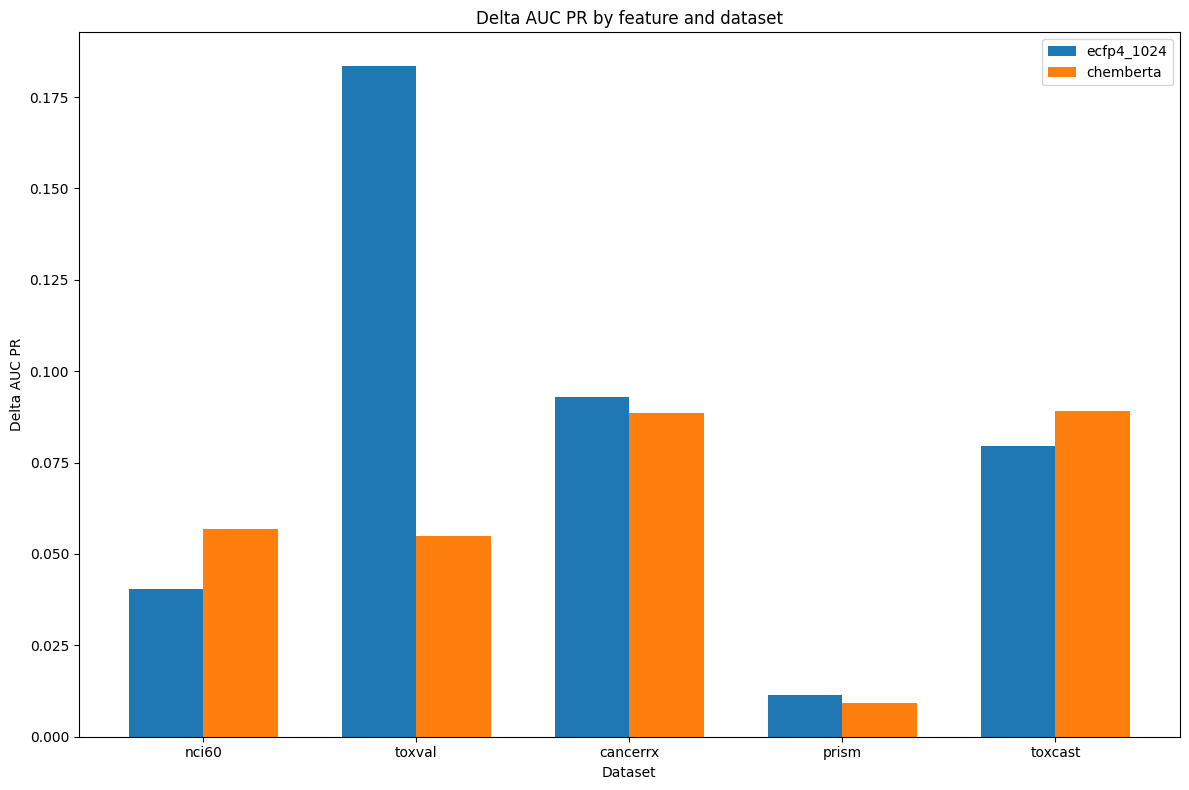

In [6]:
import numpy as np

datasets = df_final["dataset"].unique().tolist()
features = df_final["feature"].unique().tolist()
feature_width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Create an array of dataset indices for plot positioning
dataset_indices = np.arange(len(datasets))

for idx, feature in enumerate(features):
    feature_data = df_final[df_final["feature"] == feature]
    median_values = [feature_data[feature_data["dataset"] == dataset]["delta_auc_pr"].median() for dataset in datasets]
    rects = ax.bar(dataset_indices - feature_width/2 + idx*feature_width, median_values, feature_width, label=feature)

ax.set_xlabel('Dataset')
ax.set_ylabel('Delta AUC PR')
ax.set_title('Delta AUC PR by feature and dataset')
ax.set_xticks(dataset_indices)
ax.set_xticklabels(datasets)
ax.legend()

plt.tight_layout()
plt.show()